# <center> Urban Growth Prediction with Machine Learning <br> <b> GIS Capstone Project </b> </center>

<center> 
  <img src="cover.png"/>
</center>

## <center> The capstone project compiled by: Mikre Getu Mihrete  <br> Email:- mikregetuinfo@gmail.com </center>

## Import python libraries

In [2]:
import numpy as np
import rasterio
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time

### Define file paths and Class names corresponding to the labels

In [3]:

# --- Helper function for visualization ---
def stretch_image_percentile(image, p_min=2, p_max=98):
    """
    Stretches the image to a new 0-255 range based on percentiles.
    This improves visual contrast by ignoring outlier pixels.
    """
    out = np.zeros_like(image, dtype=np.uint8)
    for i in range(image.shape[2]):
        channel = image[:, :, i]
        min_val = np.percentile(channel, p_min)
        max_val = np.percentile(channel, p_max)
        channel = np.clip(channel, min_val, max_val)
        out[:, :, i] = ((channel - min_val) / (max_val - min_val) * 255).astype(np.uint8)
    return out

# Define file paths
train_data_file = "./Raster/S2A_MSIL1C_20220516_TrainingData.tif"
train_gt_file = "./Raster/S2A_MSIL1C_20220516_Train_GT.tif"
test_data_file = "./Raster/S2B_MSIL1C_20220528_Test.tif"

# Class names corresponding to the labels
class_names = {
    10: "Water",
    20: "Bare Soil",
    30: "Dense Vegetation",
    40: "Cropland",
    50: "Urban / Built-up",
    60: "Sparse Vegetation",
    80: "Urban",
    90: "Cloud/Shadow"
}

# --- 1. Read and Process the Data ---

In [4]:

# --- 1. Read and Process the Data ---
print("Reading and processing training data...")
with rasterio.open(train_data_file) as src:
    train_data = src.read()
    profile = src.profile
    transform = src.transform
    height, width = src.height, src.width
    count = src.count

print(f"Training data dimensions: {train_data.shape}")
print(f"Number of bands: {count}")

with rasterio.open(train_gt_file) as src:
    train_gt = src.read(1)

print(f"Ground truth data dimensions: {train_gt.shape}")

# Reshape data for scikit-learn
X = train_data.transpose(1, 2, 0).reshape(-1, count)
y = train_gt.flatten()

print(f"Reshaped feature data (X) shape: {X.shape}")
print(f"Reshaped label data (y) shape: {y.shape}")

# Filter out NoData values
valid_pixels = y != 0
X_filtered = X[valid_pixels]
y_filtered = y[valid_pixels]

print(f"Number of valid pixels: {len(y_filtered)}")
unique_labels = np.unique(y_filtered)
print(f"Unique labels in the filtered data: {unique_labels}")

Reading and processing training data...
Training data dimensions: (4, 1131, 855)
Number of bands: 4
Ground truth data dimensions: (1131, 855)
Reshaped feature data (X) shape: (967005, 4)
Reshaped label data (y) shape: (967005,)
Number of valid pixels: 965589
Unique labels in the filtered data: [10 20 30 40 50 60 80 90]


# --- 2. Data Preprocessing and Splitting ---

In [6]:
# --- 2. Data Preprocessing and Splitting ---
print("Splitting filtered data into training and validation sets...")
X_train, X_val, y_train, y_val = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

print(f"Training set size: {len(y_train)}")
print(f"Validation set size: {len(y_val)}")

Splitting filtered data into training and validation sets...
Training set size: 772471
Validation set size: 193118


# --- 3. Model Training (Random Forest Classifier) ---

In [7]:
# --- 3. Model Training (Random Forest Classifier) ---
print("\n--- Training the Random Forest model ---")
start_time = time.time()
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
end_time = time.time()
print(f"Random Forest model training complete in {end_time - start_time:.2f} seconds.")



--- Training the Random Forest model ---
Random Forest model training complete in 293.38 seconds.


# --- 4. Prediction and Evaluation on Validation Set ---

In [8]:
# --- 4. Prediction and Evaluation on Validation Set ---
print("\n--- Model Accuracy Report on Validation Set ---")
y_pred_val = rf_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred_val)

print(f"Overall Accuracy on Validation Set: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_val, target_names=[class_names[label] for label in unique_labels if label in class_names], zero_division=0))




--- Model Accuracy Report on Validation Set ---
Overall Accuracy on Validation Set: 0.9008

Classification Report:
                   precision    recall  f1-score   support

            Water       0.73      0.65      0.68     11645
        Bare Soil       0.61      0.55      0.58      3163
 Dense Vegetation       0.69      0.74      0.72     21537
         Cropland       0.48      0.13      0.20       844
 Urban / Built-up       0.79      0.88      0.83     29055
Sparse Vegetation       0.66      0.26      0.37      3013
            Urban       0.99      0.99      0.99    123504
     Cloud/Shadow       0.32      0.16      0.21       357

         accuracy                           0.90    193118
        macro avg       0.66      0.54      0.57    193118
     weighted avg       0.90      0.90      0.90    193118



#### Visualize Confusion Matrix

Confusion matrix saved to confusion_matrix.png


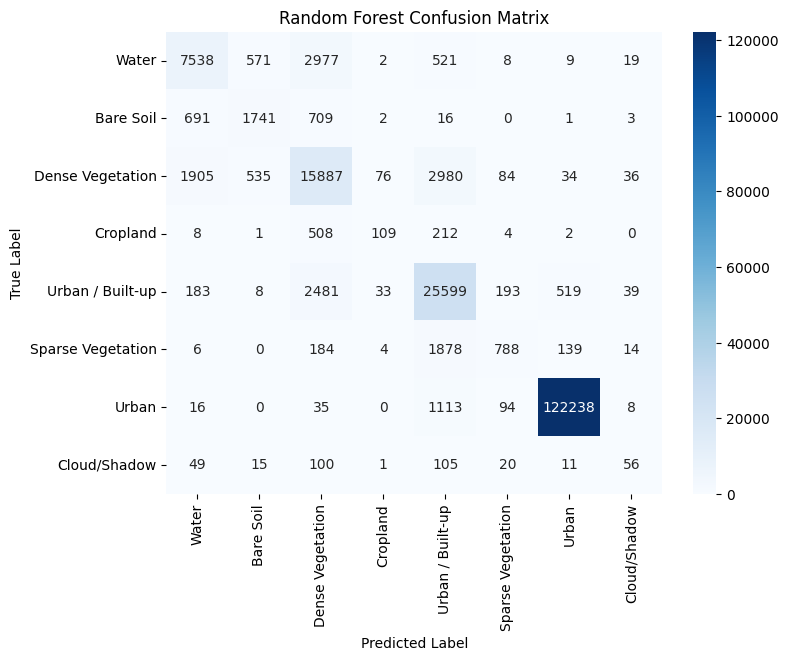

In [9]:
cm = confusion_matrix(y_val, y_pred_val)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[class_names[label] for label in unique_labels if label in class_names],
            yticklabels=[class_names[label] for label in unique_labels if label in class_names])
plt.title('Random Forest Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig("confusion_matrix.png")
print("Confusion matrix saved to confusion_matrix.png")


# --- 5. Prediction on the Test Raster (with batching) ---

In [10]:
# --- 5. Prediction on the Test Raster (with batching) ---
print("\nPredicting on the test raster...")
with rasterio.open(test_data_file) as src_test:
    test_data = src_test.read()
    test_profile = src_test.profile
    test_height, test_width = src_test.height, src_test.width
    test_count = src_test.count

X_test = test_data.transpose(1, 2, 0).reshape(-1, test_count)

# Batch processing to avoid MemoryError
batch_size = 100000
num_batches = int(np.ceil(len(X_test) / batch_size))

predicted_labels = []
predicted_probabilities = []

print(f"Processing test data in {num_batches} batches of size {batch_size}...")
for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(X_test))
    X_batch = X_test[start_idx:end_idx]

    predicted_labels.append(rf_model.predict(X_batch))
    predicted_probabilities.append(rf_model.predict_proba(X_batch))
    print(f"Batch {i+1}/{num_batches} processed.")

predicted_labels = np.concatenate(predicted_labels)
predicted_probabilities = np.concatenate(predicted_probabilities)

predicted_map = predicted_labels.reshape(test_height, test_width)

classes = rf_model.classes_
urban_class_index = np.where(classes == 50)[0][0]
urban_risk_map = predicted_probabilities[:, urban_class_index].reshape(test_height, test_width)



Predicting on the test raster...
Processing test data in 47 batches of size 100000...
Batch 1/47 processed.
Batch 2/47 processed.
Batch 3/47 processed.
Batch 4/47 processed.
Batch 5/47 processed.
Batch 6/47 processed.
Batch 7/47 processed.
Batch 8/47 processed.
Batch 9/47 processed.
Batch 10/47 processed.
Batch 11/47 processed.
Batch 12/47 processed.
Batch 13/47 processed.
Batch 14/47 processed.
Batch 15/47 processed.
Batch 16/47 processed.
Batch 17/47 processed.
Batch 18/47 processed.
Batch 19/47 processed.
Batch 20/47 processed.
Batch 21/47 processed.
Batch 22/47 processed.
Batch 23/47 processed.
Batch 24/47 processed.
Batch 25/47 processed.
Batch 26/47 processed.
Batch 27/47 processed.
Batch 28/47 processed.
Batch 29/47 processed.
Batch 30/47 processed.
Batch 31/47 processed.
Batch 32/47 processed.
Batch 33/47 processed.
Batch 34/47 processed.
Batch 35/47 processed.
Batch 36/47 processed.
Batch 37/47 processed.
Batch 38/47 processed.
Batch 39/47 processed.
Batch 40/47 processed.
Ba

# --- 6. Save the Output Rasters ---

In [11]:
# --- 6. Save the Output Rasters ---
print(f"Saving urban risk map to urban_risk_map.tif...")
test_profile.update(dtype=rasterio.float32, count=1, compress='lzw')
with rasterio.open("urban_risk_map.tif", 'w', **test_profile) as dst:
    dst.write(urban_risk_map.astype(rasterio.float32), 1)

print(f"Saving predicted urban growth map to predicted_urban_growth.tif...")
test_profile.update(dtype=rasterio.int16, count=1)
with rasterio.open("predicted_urban_growth.tif", 'w', **test_profile) as dst:
    dst.write(predicted_map.astype(rasterio.int16), 1)

Saving urban risk map to urban_risk_map.tif...
Saving predicted urban growth map to predicted_urban_growth.tif...


# --- 7. Multiple Visualizations ---

All visualizations saved to results_visualization.png


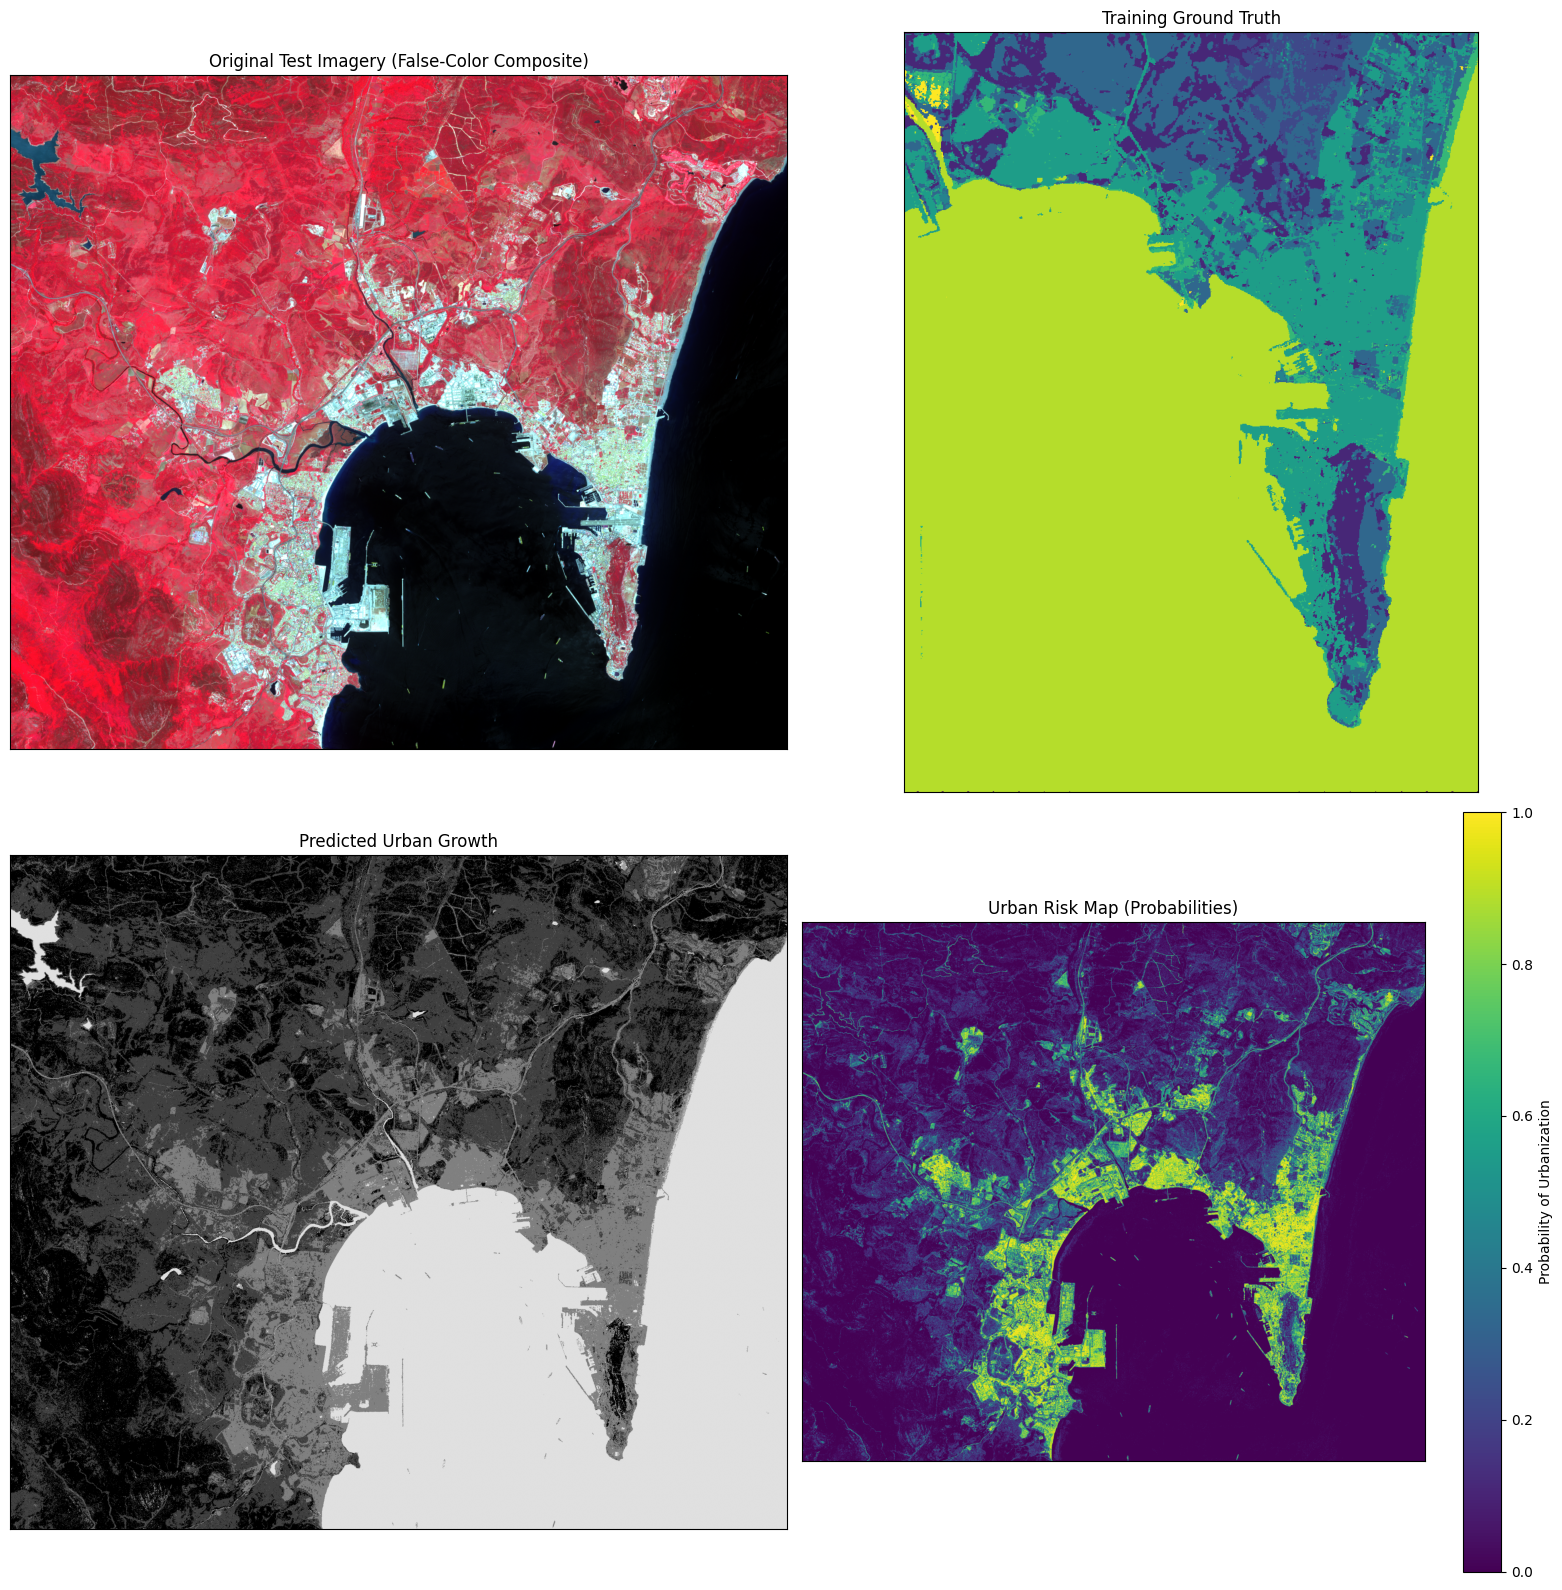

In [12]:
# --- 7. Multiple Visualizations ---
with rasterio.open(test_data_file) as src_test:
    test_data_vis = src_test.read()

with rasterio.open(train_gt_file) as src_gt:
    train_gt_vis = src_gt.read(1)

fig, axes = plt.subplots(2, 2, figsize=(16, 16))

# Original Test Imagery (False-color composite: NIR, Red, Green)
rgb_composite = np.stack([test_data_vis[3, :, :], test_data_vis[2, :, :], test_data_vis[1, :, :]], axis=-1)
axes[0, 0].imshow(stretch_image_percentile(rgb_composite))
axes[0, 0].set_title('Original Test Imagery (False-Color Composite)')
axes[0, 0].set_xticks([])
axes[0, 0].set_yticks([])

# Training Ground Truth
axes[0, 1].imshow(train_gt_vis, cmap='viridis')
axes[0, 1].set_title('Training Ground Truth')
axes[0, 1].set_xticks([])
axes[0, 1].set_yticks([])

# Final Predicted Urban Growth
axes[1, 0].imshow(predicted_map, cmap='gray')
axes[1, 0].set_title('Predicted Urban Growth')
axes[1, 0].set_xticks([])
axes[1, 0].set_yticks([])

# Urban Risk Map (Probabilities)
im = axes[1, 1].imshow(urban_risk_map, cmap='viridis', vmin=0, vmax=1)
axes[1, 1].set_title('Urban Risk Map (Probabilities)')
axes[1, 1].set_xticks([])
axes[1, 1].set_yticks([])
fig.colorbar(im, ax=axes[1, 1], label='Probability of Urbanization')

plt.tight_layout()
plt.savefig("results_visualization.png")
print("All visualizations saved to results_visualization.png")